# **Data Cleaning**

In [25]:
import pandas as pd
import numpy as np
import os
from datetime import timedelta
from google.colab import files

# Define directories
output_dir = "/content"
report_dir = "/content"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(report_dir, exist_ok=True)

# --- 1. Flu Data Preprocessing ---
flu_file = "/content/Flu.csv"

print("Please upload the Flu.csv file")
uploaded = files.upload()
for filename in uploaded.keys():
    os.rename(filename, flu_file)
    print(f"Uploaded file moved to {flu_file}")

print("Processing Flu.csv...")
flu_df = pd.read_csv(flu_file)
# Use 'From' date as the representative date for the week
flu_df["Date"] = pd.to_datetime(flu_df["From"], format="%d/%m/%Y")
# Select relevant columns and rename for clarity
flu_df = flu_df[["Date", "Year", "Week", "ILI_PMP"]]
flu_df.rename(columns={"ILI_PMP": "Flu_Index"}, inplace=True)
# Handle missing values in Flu_Index (e.g., forward fill then backward fill)
flu_df["Flu_Index"].ffill(inplace=True)
flu_df["Flu_Index"].bfill(inplace=True)
flu_df.sort_values(by="Date", inplace=True)
print(f"Flu data processed. Shape: {flu_df.shape}")

# --- 2. Temperature Data Preprocessing ---
temp_file = "/content/Temperature.csv"

print("Please upload the Temperature.csv file")
uploaded = files.upload()
for filename in uploaded.keys():
    os.rename(filename, temp_file)
    print(f"Uploaded file moved to {temp_file}")

print("Processing Temperature.csv...")
temp_df = pd.read_csv(temp_file, skiprows=2)
# Rename columns for easier use
temp_df.columns = ["Year_str", "Month", "Day", "Temperature", "Completeness"]
# Clean Year_str: remove any non-numeric characters and convert to numeric
temp_df["Year"] = temp_df["Year_str"].astype(str).str.split("-").str[0].str.extract("(\\d+)").astype(float)

# Drop rows where Year, Month, or Day might be NaN
temp_df.dropna(subset=["Year", "Month", "Day", "Temperature"], inplace=True)

temp_df["Year"] = temp_df["Year"].astype(int)
temp_df["Month"] = temp_df["Month"].astype(int)
temp_df["Day"] = temp_df["Day"].astype(int)

# Create Date column
temp_df["Date"] = pd.to_datetime(temp_df[["Year", "Month", "Day"]], errors="coerce")
temp_df.dropna(subset=["Date"], inplace=True)

temp_df = temp_df[["Date", "Temperature"]]
# Aggregate daily temperature to weekly average
temp_df.set_index("Date", inplace=True)
weekly_temp_df = temp_df["Temperature"].resample("W-SUN").mean().reset_index()
print(f"Temperature data processed. Shape: {weekly_temp_df.shape}")

# --- 3. Travellers Data Preprocessing ---
travellers_file = "/content/Travellers.csv"

print("Please upload the Travellers.csv file")
uploaded = files.upload()
for filename in uploaded.keys():
    os.rename(filename, travellers_file)
    print(f"Uploaded file moved to {travellers_file}")

print("Processing Travellers.csv...")
travellers_df = pd.read_csv(travellers_file)

travellers_df.drop(columns=["Unnamed: 7"], inplace=True, errors="ignore")
travellers_df["Date"] = pd.to_datetime(travellers_df["Date"], format="%d-%m-%Y", errors="coerce")
travellers_df.dropna(subset=["Date"], inplace=True)
# Sum 'Total' travellers per day across all control points
daily_total_travellers = travellers_df.groupby("Date")["Total"].sum().reset_index()
daily_total_travellers.rename(columns={"Total": "Total_Travellers"}, inplace=True)
# Aggregate daily total travellers to weekly total
daily_total_travellers.set_index("Date", inplace=True)
weekly_travellers_df = daily_total_travellers["Total_Travellers"].resample("W-SUN").sum().reset_index()
print(f"Travellers data processed. Shape: {weekly_travellers_df.shape}")

# --- 4. Air Condition Data Preprocessing ---
air_file = "/content/Air_Condition.csv"

print("Please upload the Air_Condition.csv file")
uploaded = files.upload()
for filename in uploaded.keys():
    os.rename(filename, air_file)
    print(f"Uploaded file moved to {air_file}")

print("Processing Air_Condition.csv...")
air_df = pd.read_csv(air_file, skiprows=5)
# Rename columns for easier access
month_cols_map = {f"{str(i).zfill(2)}月": f"Month_{i}" for i in range(1, 13)}
air_df.rename(columns=month_cols_map, inplace=True)
air_df.rename(columns={"年": "Year", "污染物": "Pollutant", "監測站": "Station"}, inplace=True)

# Melt dataframe to long format
id_vars = ["Year", "Pollutant", "Station"]
value_vars = [col for col in air_df.columns if col.startswith("Month_")]
air_long_df = pd.melt(air_df, id_vars=id_vars, value_vars=value_vars, var_name="Month_Str", value_name="Value")

# Convert Value to numeric, coercing 'N.A.' to NaN
air_long_df["Value"] = pd.to_numeric(air_long_df["Value"], errors="coerce")
# Extract month number from Month_Str
air_long_df["Month"] = air_long_df["Month_Str"].str.replace("Month_", "").astype(int)

# Create Date column (first day of the month)
air_long_df["Date"] = pd.to_datetime(air_long_df["Year"].astype(str) + "-" + air_long_df["Month"].astype(str) + "-01", errors="coerce")
air_long_df.dropna(subset=["Date"], inplace=True)

# Select relevant pollutants and rename
pollutant_map = {
    '一氧化碳': 'CO',
    '二氧化硫': 'SO2',
    '可吸入懸浮粒子': 'PM10',
    '微細懸浮粒子': 'PM2.5'
}
air_long_df = air_long_df[air_long_df["Pollutant"].isin(pollutant_map.keys())]
air_long_df["Pollutant"] = air_long_df["Pollutant"].map(pollutant_map)

# Pivot to have pollutants as columns
air_monthly_avg_df = air_long_df.groupby(["Date", "Pollutant"])["Value"].mean().unstack()
air_monthly_avg_df.reset_index(inplace=True)

# Convert monthly air quality data to weekly
air_monthly_avg_df.set_index("Date", inplace=True)
daily_air_df = air_monthly_avg_df.resample("D").ffill()
weekly_air_df = daily_air_df.resample("W-SUN").mean().reset_index()
print(f"Air condition data processed. Shape: {weekly_air_df.shape}")

# --- 5. Merging Datasets ---
print("Merging datasets...")
# Start with flu_df as the base
merged_df = flu_df.copy()

# Merge with weekly temperature
merged_df = pd.merge(merged_df, weekly_temp_df, on="Date", how="left")

# Merge with weekly travellers
merged_df = pd.merge(merged_df, weekly_travellers_df, on="Date", how="left")

# Merge with weekly air quality
merged_df = pd.merge(merged_df, weekly_air_df, on="Date", how="left")

print(f"Merged data shape: {merged_df.shape}")

# --- 6. Final Cleaning of Merged Data ---
print("Final cleaning of merged data...")
# Handle missing values
numeric_cols = merged_df.select_dtypes(include=np.number).columns
merged_df[numeric_cols] = merged_df[numeric_cols].ffill().bfill()

shape_before_final_dropna = merged_df.shape
# Drop rows if essential data is still missing
merged_df.dropna(subset=["Flu_Index", "Temperature", "Total_Travellers"], inplace=True)

# Select and rename columns to match required output
final_columns = ["Date", "Year", "Week", "Flu_Index", "Temperature", "Total_Travellers", "CO", "SO2", "PM10", "PM2.5"]
merged_df = merged_df[final_columns]

# Sort by date
merged_df.sort_values(by="Date", inplace=True)

# Save the preprocessed and merged dataset
output_path = os.path.join(output_dir, "preprocessed_health_data.csv")
merged_df.to_csv(output_path, index=False, encoding="utf-8")
print(f"Preprocessed data saved to {output_path}")

# Download the file to local machine
print("Downloading preprocessed_health_data.csv to your local machine...")
files.download(output_path)

# --- Generate a brief report of preprocessing ---
report_content = f"""
Data Preprocessing Report:

1. Flu Data:
   - Loaded Flu.csv.
   - Used 'From' date as the weekly representative date.
   - Selected 'ILI_PMP' as 'Flu_Index'.
   - Handled missing 'Flu_Index' values using ffill/bfill.
   - Final shape: {flu_df.shape}

2. Temperature Data:
   - Loaded Temperature.csv, skipped first 2 rows.
   - Created 'Date' column from Year, Month, Day.
   - Aggregated daily temperature to weekly average (W-SUN).
   - Final shape for weekly data: {weekly_temp_df.shape}

3. Travellers Data:
   - Loaded Travellers.csv, dropped 'Unnamed: 7'.
   - Parsed 'Date' column.
   - Aggregated 'Total' travellers to daily sum, then to weekly sum (W-SUN).
   - Final shape for weekly data: {weekly_travellers_df.shape}

4. Air Condition Data:
   - Loaded Air_Condition.csv, skipped first 5 rows.
   - Melted data from wide to long format.
   - Converted monthly pollutant values to numeric (N.A. to NaN).
   - Created 'Date' column (first day of month).
   - Selected pollutants: CO, SO2, PM10, PM2.5.
   - Averaged pollutant values across stations and unstacked pollutants into columns.
   - Forward-filled monthly data to daily, then resampled to weekly mean (W-SUN).
   - Final shape for weekly data: {weekly_air_df.shape}

5. Merging:
   - Merged all processed weekly datasets with Flu data as base, using 'Date' as key
   - Initial merged shape: {shape_before_final_dropna}

6. Final Cleaning:
   - Handled missing values in the merged dataset for numeric columns using ffill/bfill.
   - Dropped rows where 'Flu_Index', 'Temperature', or 'Total_Travellers' were still NaN.
   - Final preprocessed dataset shape: {merged_df.shape}
   - Final columns: {', '.join(final_columns)}
   - Saved to: {output_path}
"""

report_file_path = os.path.join(report_dir, "data_preprocessing_summary.txt")
with open(report_file_path, "w", encoding="utf-8") as f:
    f.write(report_content)
print(f"Preprocessing summary saved to {report_file_path}")

print("Data preprocessing script finished.")

Please upload the Flu.csv file


Saving Flu.csv to Flu (1).csv
Uploaded file moved to /content/Flu.csv
Processing Flu.csv...
Flu data processed. Shape: (593, 4)
Please upload the Temperature.csv file


<ipython-input-25-78d30f93823a>:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  flu_df["Flu_Index"].ffill(inplace=True)
<ipython-input-25-78d30f93823a>:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

Saving Temperature.csv to Temperature (1).csv
Uploaded file moved to /content/Temperature.csv
Processing Temperature.csv...
Temperature data processed. Shape: (4088, 2)
Please upload the Travellers.csv file


Saving Travellers.csv to Travellers (1).csv
Uploaded file moved to /content/Travellers.csv
Processing Travellers.csv...
Travellers data processed. Shape: (229, 2)
Please upload the Air_Condition.csv file


Saving Air_Condition.csv to Air_Condition (1).csv
Uploaded file moved to /content/Air_Condition.csv
Processing Air_Condition.csv...
Air condition data processed. Shape: (518, 5)
Merging datasets...
Merged data shape: (593, 10)
Final cleaning of merged data...
Preprocessed data saved to /content/preprocessed_health_data.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Preprocessing summary saved to /content/data_preprocessing_summary.txt
Data preprocessing script finished.


# **Data Displaying (Air Condition & Flu Index)**

In [31]:
import pandas as pd
import os

# Define the path for the preprocessed file directly in /content
preprocessed_file = "/content/preprocessed_health_data.csv"

# Upload the preprocessed CSV file if it doesn't exist
print("Please upload the preprocessed_health_data.csv file")
uploaded = files.upload()
# Move the uploaded file to /content
for filename in uploaded.keys():
    os.rename(filename, preprocessed_file)
    print(f"Uploaded file moved to {preprocessed_file}")

def display_latest_health_data(data_file_path):
    """
    Loads the preprocessed health data, extracts, and displays the latest
    Flu Index and Air Quality information.
    """
    try:
        df = pd.read_csv(data_file_path)
    except FileNotFoundError:
        print(f"Error: The data file was not found at {data_file_path}")
        print("Please ensure the data_preprocessing.py script has been run successfully.")
        return
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    if df.empty:
        print("The preprocessed data is empty. Cannot display latest information.")
        return

    # Convert 'Date' column to datetime objects
    df["Date"] = pd.to_datetime(df["Date"])
    # Sort by date to easily get the latest entry
    df.sort_values(by="Date", ascending=False, inplace=True)

    latest_data = df.iloc[0]
    latest_date = latest_data["Date"].strftime("%Y-%m-%d")

    print("--- HealthPulse Data Display ---")
    print(f"Latest Data as of: {latest_date}\n")

    # 1. Display Flu Index
    flu_index = latest_data.get("Flu_Index")
    if pd.notna(flu_index):
        print(f"** Latest Flu Index (ILI_PMP): {flu_index:.2f} **\n")
    else:
        print("** Latest Flu Index (ILI_PMP): Data not available **\n")

    # 2. Display Air Quality Data
    print("** Latest Air Quality Data: **")
    # Identify air quality columns (these were unstacked during preprocessing)
    # Common pollutants in Hong Kong data include:
    # '二氧化硫' (SO2), '二氧化氮' (NO2), '臭氧' (O3), '一氧化碳' (CO)
    # '可吸入懸浮粒子' (RSP/PM10), '微細懸浮粒子' (FSP/PM2.5)
    # The actual column names will depend on what was in Air_Condition.csv and successfully processed.
    air_quality_cols = [
        "一氧化碳", "二氧化氮", "二氧化硫", "臭氧",
        "可吸入懸浮粒子", "微細懸浮粒子" # These are common, actual cols might vary
    ]

    air_quality_found = False
    for col_name_ch in air_quality_cols:
        # Check if the column exists in the dataframe (it might not if data was missing)
        if col_name_ch in latest_data.index and pd.notna(latest_data[col_name_ch]):
            # Attempt to map to English for better readability if desired, or keep original
            # For now, using original names as per preprocessing output
            print(f"  - {col_name_ch}: {latest_data[col_name_ch]:.2f}")
            air_quality_found = True
        elif col_name_ch in latest_data.index and pd.isna(latest_data[col_name_ch]):
            print(f"  - {col_name_ch}: Data not available for this date")
            air_quality_found = True # Column exists but value is NA

    if not air_quality_found:
        print("  Available columns in latest record:")
        for col, val in latest_data.items():
            if col not in ["Date", "Year", "Week", "Flu_Index", "Temperature", "Total_Travellers"]:
                 if pd.notna(val):
                    print(f"    - {col}: {val}")
                 else:
                    print(f"    - {col}: Not Available")

    print("\n--- End of Display ---")

if __name__ == "__main__":
    # This script is intended to be a module, but can be run directly for testing.
    print("Executing HealthPulse Data Display (data_display.py)...\n")
    display_latest_health_data(preprocessed_file)

Please upload the preprocessed_health_data.csv file


Saving preprocessed_health_data.csv to preprocessed_health_data (1).csv
Uploaded file moved to /content/preprocessed_health_data.csv
Executing HealthPulse Data Display (data_display.py)...

--- HealthPulse Data Display ---
Latest Data as of: 2025-05-04

** Latest Flu Index (ILI_PMP): 44.00 **

** Latest Air Quality Data: **
  Available columns in latest record:
    - CO: 57.32467532467533
    - SO2: 3.2777777777777777
    - PM10: 28.63492063492064
    - PM2.5: 18.325396825396822

--- End of Display ---


# **Flu Notification**

In [29]:
import datetime
import time

def get_latest_flu_notifications():
    """
    Conceptual function to fetch the latest flu notifications.
    In a real application, this would connect to an API or scrape a website.
    For this project, it returns a placeholder message.
    """
    current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    placeholder_notification = {
        "date": current_time,
        "title": "Placeholder Flu Alert: Maintain Good Personal Hygiene",
        "summary": "This is a simulated flu notification. In a real system, this would contain the latest advice from the Centre for Health Protection (CHP), Hong Kong.",
        "source": "HealthPulse Conceptual Module (CHP Placeholder)"
    }
    return placeholder_notification

def display_notification(notification):
    """
    Displays a given notification in a user-friendly format.
    """
    print("--- Latest Flu Notification ---")
    print(f"Date: {notification['date']}")
    print(f"Title: {notification['title']}")
    print(f"Summary: {notification['summary']}")
    print(f"Source: {notification['source']}")
    print("-------------------------------")

def main():
    """
    Main function to demonstrate the flu notification functionality.
    Simulates checking for notifications every 10 seconds for 3 iterations.
    """
    print("Starting Flu Notification Demo (Conceptual)...\n")
    print("This demo will check for new notifications 3 times, with a 10-second pause between checks.\n")

    for i in range(3):
        print(f"Check {i+1} of 3:")
        notification = get_latest_flu_notifications()
        display_notification(notification)
        if i < 2:  # Don't wait after the last iteration
            print("Waiting 10 seconds before next check...\n")
            time.sleep(10)

    print("\nDemo complete. Note: This is a conceptual example using placeholder data.")

if __name__ == "__main__":
    main()

Starting Flu Notification Demo (Conceptual)...

This demo will check for new notifications 3 times, with a 10-second pause between checks.

Check 1 of 3:
--- Latest Flu Notification ---
Date: 2025-05-16 10:59:12
Title: Placeholder Flu Alert: Maintain Good Personal Hygiene
Summary: This is a simulated flu notification. In a real system, this would contain the latest advice from the Centre for Health Protection (CHP), Hong Kong.
Source: HealthPulse Conceptual Module (CHP Placeholder)
-------------------------------
Waiting 10 seconds before next check...

Check 2 of 3:
--- Latest Flu Notification ---
Date: 2025-05-16 10:59:22
Title: Placeholder Flu Alert: Maintain Good Personal Hygiene
Summary: This is a simulated flu notification. In a real system, this would contain the latest advice from the Centre for Health Protection (CHP), Hong Kong.
Source: HealthPulse Conceptual Module (CHP Placeholder)
-------------------------------
Waiting 10 seconds before next check...



KeyboardInterrupt: 

# **Flu Trend Prediction**

Please upload the preprocessed_health_data.csv file


Saving preprocessed_health_data.csv to preprocessed_health_data.csv
Uploaded file moved to /content/preprocessed_health_data.csv
Executing Flu Trend Prediction script (flu_prediction.py)...

Loading data from /content/preprocessed_health_data.csv...
Preparing features and target variable...
Selected features: ['Temperature', 'Total_Travellers', 'CO', 'SO2', 'PM10', 'PM2.5']
Training data shape: X_train (474, 6), y_train (474,)
Testing data shape: X_test (119, 6), y_test (119,)
Training Random Forest Regressor model...
Making predictions on the test set...
Evaluating model performance...
  Mean Absolute Error (MAE): 22.01
  Mean Squared Error (MSE): 600.50
  Root Mean Squared Error (RMSE): 24.51
  R-squared (R2): -3.71
Prediction metrics saved to /content/flu_prediction_metrics.txt
Generating and displaying visualizations...


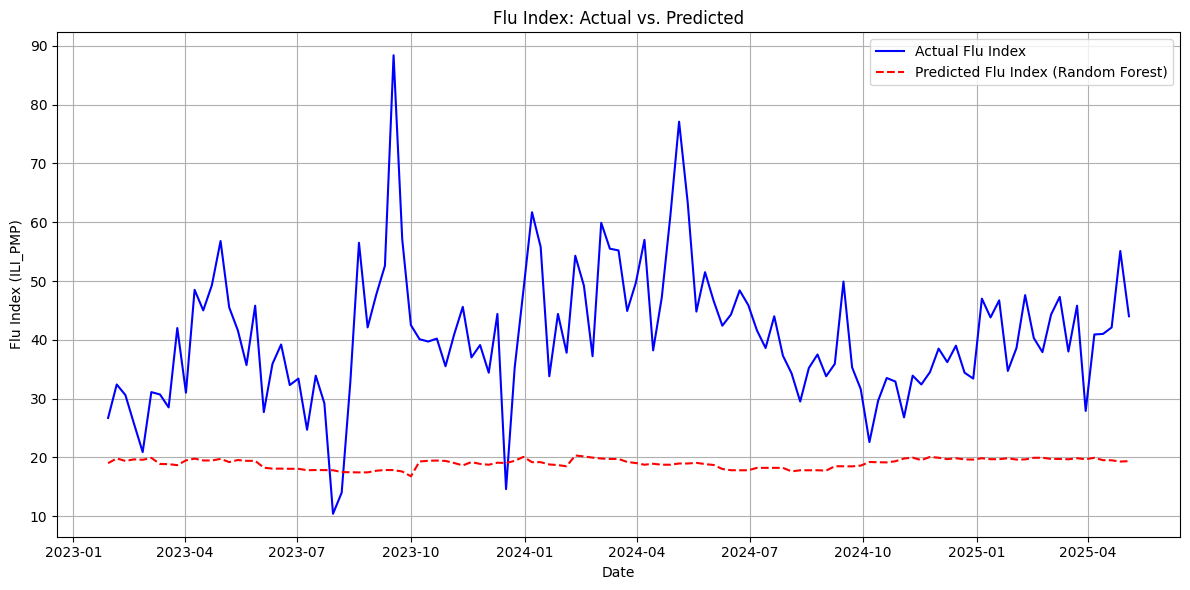

Actual vs. Predicted plot saved to /content/actual_vs_predicted_flu_index.png


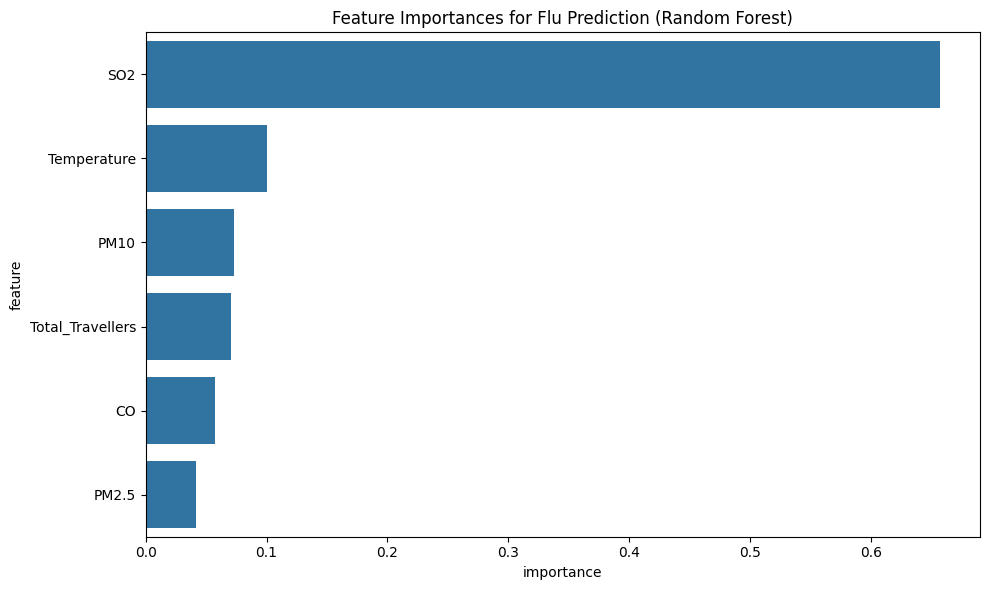

Feature importance plot saved to /content/feature_importances_flu.png


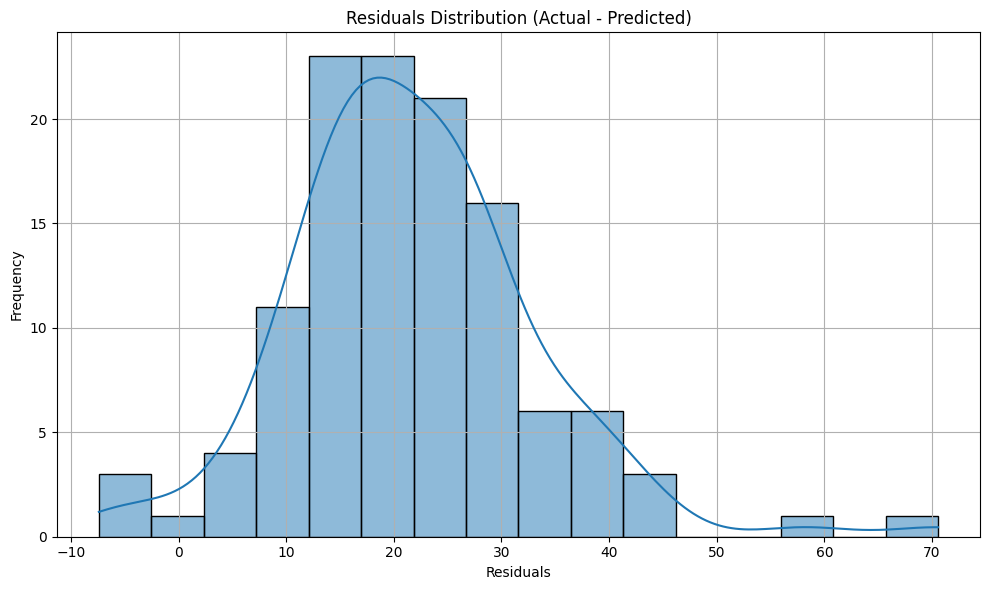

Residuals plot saved to /content/residuals_distribution_flu.png
Flu prediction model training and evaluation complete.

Generated visualization files: ('/content/actual_vs_predicted_flu_index.png', '/content/feature_importances_flu.png', '/content/residuals_distribution_flu.png')

Script finished.


In [1]:
# 1. Random Forest
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Define the path for the preprocessed file directly in /content
preprocessed_file = "/content/preprocessed_health_data.csv"

# Upload the preprocessed CSV file if it doesn't exist
print("Please upload the preprocessed_health_data.csv file")
uploaded = files.upload()
# Move the uploaded file to /content
for filename in uploaded.keys():
    os.rename(filename, preprocessed_file)
    print(f"Uploaded file moved to {preprocessed_file}")

def train_and_evaluate_flu_prediction_model(data_file_path):
    """
    Loads preprocessed data, trains a Random Forest Regressor model to predict Flu_Index,
    evaluates its performance, and displays visualizations.
    """
    print(f"Loading data from {data_file_path}...")
    try:
        df = pd.read_csv(data_file_path, parse_dates=["Date"])
    except FileNotFoundError:
        print(f"Error: Preprocessed data file not found at {data_file_path}.")
        return
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    if df.empty:
        print("Preprocessed data is empty. Cannot train model.")
        return

    df.sort_values(by="Date", inplace=True)
    df.set_index("Date", inplace=True)  # Set Date as index for time series operations

    print("Preparing features and target variable...")
    # Define target variable
    target = "Flu_Index"
    if target not in df.columns:
        print(f"Error: Target column '{target}' not found in the dataframe.")
        return
    y = df[target]
    # Air quality columns are identified as those not in the fixed list of other columns
    fixed_cols = ["Year", "Week", "Flu_Index", "Temperature", "Total_Travellers"]
    air_quality_feature_cols = [col for col in df.columns if col not in fixed_cols and df[col].dtype in [np.float64, np.int64]]

    feature_cols = ["Temperature", "Total_Travellers"] + air_quality_feature_cols

    print(f"Selected features: {feature_cols}")
    X = df[feature_cols]

    # Handle any remaining NaN values in features
    for col in X.columns:
        if X[col].isnull().any():
            print(f"Warning: Feature '{col}' has {X[col].isnull().sum()} NaN values. Filling with median.")
            X[col].fillna(X[col].median(), inplace=True)

    if X.isnull().values.any():
        print("Error: NaN values still present in features after attempting to fill. Please check data.")
        print(X.isnull().sum())
        return

    # Split data into training and testing sets (chronological split for time series)
    split_point = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
    y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

    print(f"Training data shape: X_train {X_train.shape}, y_train {y_train.shape}")
    print(f"Testing data shape: X_test {X_test.shape}, y_test {y_test.shape}")

    if X_train.empty or X_test.empty:
        print("Error: Training or testing set is empty. Check data splitting.")
        return

    print("Training Random Forest Regressor model...")
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_split=5, min_samples_leaf=3)

    try:
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"Error during model training: {e}")
        print("NaNs in X_train:")
        print(X_train.isnull().sum())
        print("NaNs in y_train:")
        print(y_train.isnull().sum())
        return

    print("Making predictions on the test set...")
    y_pred = model.predict(X_test)

    print("Evaluating model performance...")
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"  Mean Absolute Error (MAE): {mae:.2f}")
    print(f"  Mean Squared Error (MSE): {mse:.2f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"  R-squared (R2): {r2:.2f}")

    # Store metrics for the report
    metrics_summary = f"""
Flu Prediction Model Evaluation (Random Forest Regressor):
- Features: {feature_cols}
- Target: {target}
- Training set size: {len(X_train)}
- Testing set size: {len(X_test)}
- MAE: {mae:.2f}
- MSE: {mse:.2f}
- RMSE: {rmse:.2f}
- R2 Score: {r2:.2f}
Model Parameters: {model.get_params()}
"""
    metrics_file = "/content/flu_prediction_metrics.txt"
    with open(metrics_file, "w", encoding="utf-8") as f:
        f.write(metrics_summary)
    print(f"Prediction metrics saved to {metrics_file}")

    print("Generating and displaying visualizations...")
    # 1. Actual vs. Predicted Plot
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label="Actual Flu Index", color="blue")
    plt.plot(y_test.index, y_pred, label="Predicted Flu Index (Random Forest)", color="red", linestyle="--")
    plt.title("Flu Index: Actual vs. Predicted")
    plt.xlabel("Date")
    plt.ylabel("Flu Index (ILI_PMP)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    actual_vs_predicted_path = "/content/actual_vs_predicted_flu_index.png"
    plt.savefig(actual_vs_predicted_path)
    plt.show()  # Display the plot in Colab output
    plt.close()
    print(f"Actual vs. Predicted plot saved to {actual_vs_predicted_path}")

    # 2. Feature Importance Plot
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({"feature": X.columns, "importance": importances})
        feature_importance_df.sort_values(by="importance", ascending=False, inplace=True)

        plt.figure(figsize=(10, max(6, len(X.columns) * 0.3)))
        sns.barplot(x="importance", y="feature", data=feature_importance_df)
        plt.title("Feature Importances for Flu Prediction (Random Forest)")
        plt.tight_layout()
        feature_importance_path = "/content/feature_importances_flu.png"
        plt.savefig(feature_importance_path)
        plt.show()  # Display the plot in Colab output
        plt.close()
        print(f"Feature importance plot saved to {feature_importance_path}")

    # 3. Residuals Plot
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title("Residuals Distribution (Actual - Predicted)")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    residuals_path = "/content/residuals_distribution_flu.png"
    plt.savefig(residuals_path)
    plt.show()  # Display the plot in Colab output
    plt.close()
    print(f"Residuals plot saved to {residuals_path}")

    print("Flu prediction model training and evaluation complete.")
    return actual_vs_predicted_path, feature_importance_path if hasattr(model, "feature_importances_") else None, residuals_path

if __name__ == "__main__":
    print("Executing Flu Trend Prediction script (flu_prediction.py)...\n")
    results = train_and_evaluate_flu_prediction_model(preprocessed_file)
    if results:
        print(f"\nGenerated visualization files: {results}")
    print("\nScript finished.")

In [ ]:
# 2. ANN
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import files

# Try to import TensorFlow and Keras
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    TF_AVAILABLE = True
except ImportError:
    print("TensorFlow/Keras is not installed. ANN model cannot be run.")
    TF_AVAILABLE = False

# Define the path for the preprocessed file directly in /content
preprocessed_file = "/content/preprocessed_health_data.csv"

# Upload the preprocessed CSV file if it doesn't exist
print("Please upload the preprocessed_health_data.csv file")
uploaded = files.upload()
# Move the uploaded file to /content
for filename in uploaded.keys():
    os.rename(filename, preprocessed_file)
    print(f"Uploaded file moved to {preprocessed_file}")

def train_and_evaluate_ann_model(data_file_path):
    """
    Loads preprocessed data, trains an ANN model to predict Flu_Index,
    evaluates its performance, and displays visualizations.
    """
    if not TF_AVAILABLE:
        print("Skipping ANN model training due to missing TensorFlow/Keras.")
        return None, None, None

    print(f"Loading data from {data_file_path} for ANN model...")
    try:
        df = pd.read_csv(data_file_path, parse_dates=["Date"])
    except FileNotFoundError:
        print(f"Error: Preprocessed data file not found at {data_file_path}.")
        return None, None, None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None

    if df.empty:
        print("Preprocessed data is empty. Cannot train ANN model.")
        return None, None, None

    df.sort_values(by="Date", inplace=True)
    df.set_index("Date", inplace=True)

    print("Preparing features and target variable for ANN...")
    target = "Flu_Index"
    if target not in df.columns:
        print(f"Error: Target column '{target}' not found.")
        return None, None, None
    y = df[target].values  # ANN prefers numpy arrays

    fixed_cols = ["Year", "Week", "Flu_Index", "Temperature", "Total_Travellers"]
    air_quality_feature_cols = [col for col in df.columns if col not in fixed_cols and df[col].dtype in [np.float64, np.int64]]
    feature_cols = ["Temperature", "Total_Travellers"] + air_quality_feature_cols
    print(f"Selected features for ANN: {feature_cols}")
    X = df[feature_cols].copy()

    # Handle NaN values in features (fill with median)
    for col in X.columns:
        if X[col].isnull().any():
            print(f"Warning: ANN Feature '{col}' has {X[col].isnull().sum()} NaN values. Filling with median.")
            X[col].fillna(X[col].median(), inplace=True)
    if X.isnull().values.any():
        print("Error: NaN values still present in ANN features after filling. Please check data.")
        return None, None, None

    # Chronological split for time series data
    split_point = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]
    X_test_dates = X_test.index  # Keep test index for plotting

    print(f"ANN Training data shape: X_train {X_train.shape}, y_train {y_train.shape}")
    print(f"ANN Testing data shape: X_test {X_test.shape}, y_test {y_test.shape}")

    if X_train.empty or X_test.empty:
        print("Error: ANN Training or testing set is empty.")
        return None, None, None

    # Feature Scaling - ANNs are sensitive to feature scales
    print("Scaling features for ANN...")
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    print("Building ANN model...")
    model = Sequential([
        Dense(128, activation="relu", input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1)  # Output layer for regression (linear activation)
    ])

    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"])
    model.summary()

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

    print("Training ANN model...")
    history = model.fit(
        X_train_scaled, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    print("Making predictions with ANN model on the test set...")
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = y_pred_scaled.flatten()

    print("Evaluating ANN model performance...")
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"  ANN MAE: {mae:.2f}")
    print(f"  ANN MSE: {mse:.2f}")
    print(f"  ANN RMSE: {rmse:.2f}")
    print(f"  ANN R-squared (R2): {r2:.2f}")

    # Store metrics
    metrics_summary_ann = f"""
Flu Prediction Model Evaluation (ANN):
- Features: {feature_cols}
- Target: {target}
- Training set size: {X_train_scaled.shape[0]}
- Testing set size: {X_test_scaled.shape[0]}
- MAE: {mae:.2f}
- MSE: {mse:.2f}
- RMSE: {rmse:.2f}
- R2 Score: {r2:.2f}
Model Architecture:
{model.to_json()}
"""
    metrics_file = "/content/flu_prediction_ann_metrics.txt"
    with open(metrics_file, "w", encoding="utf-8") as f:
        f.write(metrics_summary_ann)
    print(f"ANN prediction metrics saved to {metrics_file}")

    print("Generating and displaying ANN visualizations...")
    # 1. Actual vs. Predicted Plot
    plt.figure(figsize=(12, 6))
    plt.plot(X_test_dates, y_test, label="Actual Flu Index", color="blue")
    plt.plot(X_test_dates, y_pred, label="Predicted Flu Index (ANN)", color="orange", linestyle="--")
    plt.title("Flu Index: Actual vs. Predicted (ANN Model)")
    plt.xlabel("Date")
    plt.ylabel("Flu Index (ILI_PMP)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    actual_vs_predicted_ann_path = "/content/actual_vs_predicted_flu_index_ann.png"
    plt.savefig(actual_vs_predicted_ann_path)
    plt.show()  # Display in Colab output
    plt.close()
    print(f"ANN Actual vs. Predicted plot saved to {actual_vs_predicted_ann_path}")

    # 2. Training History Plot (Loss)
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("ANN Model Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    training_history_ann_path = "/content/training_history_ann.png"
    plt.savefig(training_history_ann_path)
    plt.show()  # Display in Colab output
    plt.close()
    print(f"ANN Training history plot saved to {training_history_ann_path}")

    # 3. Residuals Plot
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title("Residuals Distribution (Actual - Predicted) for ANN")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    residuals_path = "/content/residuals_distribution_flu_ann.png"
    plt.savefig(residuals_path)
    plt.show()  # Display in Colab output
    plt.close()
    print(f"ANN Residuals plot saved to {residuals_path}")

    print("ANN model training and evaluation complete.")
    return actual_vs_predicted_ann_path, training_history_ann_path, residuals_path

if __name__ == "__main__":
    if TF_AVAILABLE:
        print("Executing ANN Flu Trend Prediction script (flu_prediction_ann.py)...\n")
        results_ann = train_and_evaluate_ann_model(preprocessed_file)
        if results_ann and all(results_ann):
            print(f"\nGenerated ANN visualization and metrics files: {results_ann}")
        else:
            print("\nANN model script run completed, but some outputs might be missing due to errors.")
    else:
        print("TensorFlow/Keras not available. ANN script cannot run.")
    print("\nScript finished.")

Please upload the preprocessed_health_data.csv file


Please upload the preprocessed_health_data.csv file


Saving preprocessed_health_data.csv to preprocessed_health_data (1).csv
Uploaded file moved to /content/preprocessed_health_data.csv
Executing XGBoost Flu Trend Prediction script (flu_prediction_xgboost.py)...

Loading data from /content/preprocessed_health_data.csv for XGBoost model...
Performing feature engineering for XGBoost...
Preparing features and target variable for XGBoost...
Selected features for XGBoost: ['Year', 'Week', 'Temperature', 'Total_Travellers', 'CO', 'SO2', 'PM10', 'PM2.5', 'week_of_year', 'Flu_Index_lag_1', 'Temperature_lag_1', 'Total_Travellers_lag_1', 'Flu_Index_lag_2', 'Temperature_lag_2', 'Total_Travellers_lag_2', 'Flu_Index_lag_3', 'Temperature_lag_3', 'Total_Travellers_lag_3', 'Flu_Index_lag_4', 'Temperature_lag_4', 'Total_Travellers_lag_4']
XGBoost Training data shape: X_train (471, 21), y_train (471,)
XGBoost Testing data shape: X_test (118, 21), y_test (118,)
Building and training XGBoost model...
Making predictions with XGBoost model on the test set...


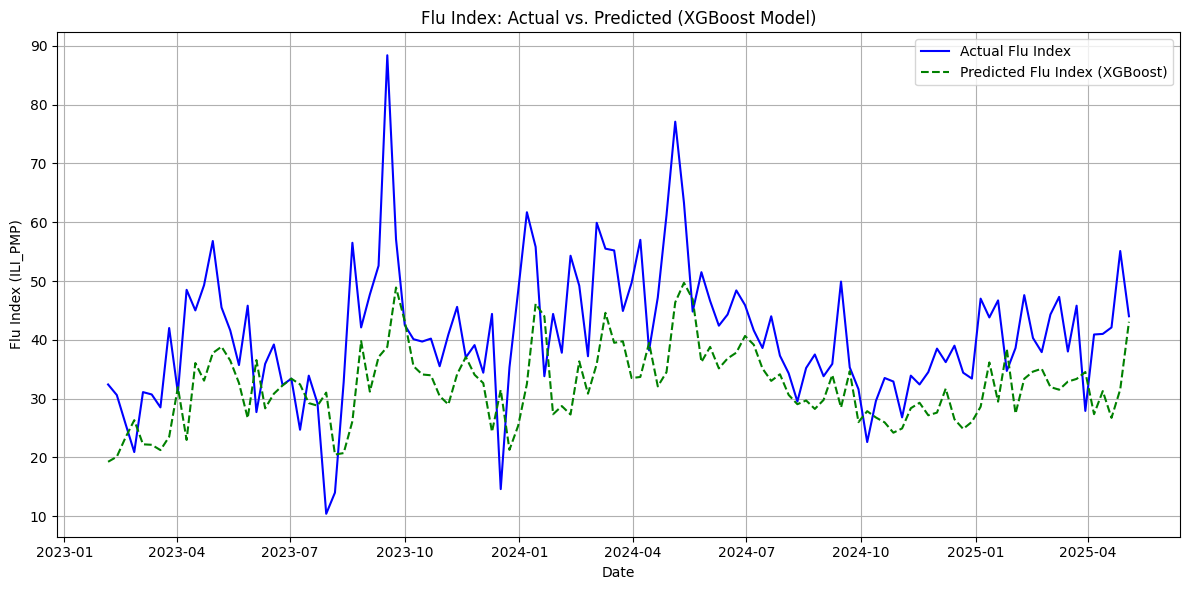

XGBoost Actual vs. Predicted plot saved to /content/actual_vs_predicted_flu_index_xgboost.png


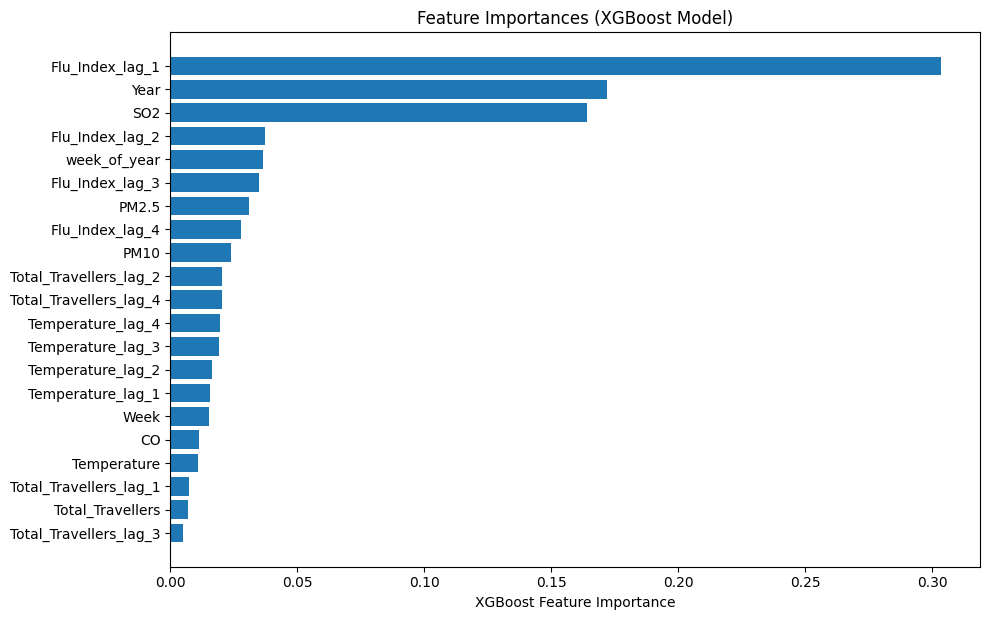

XGBoost Feature Importances plot saved to /content/feature_importances_xgboost.png


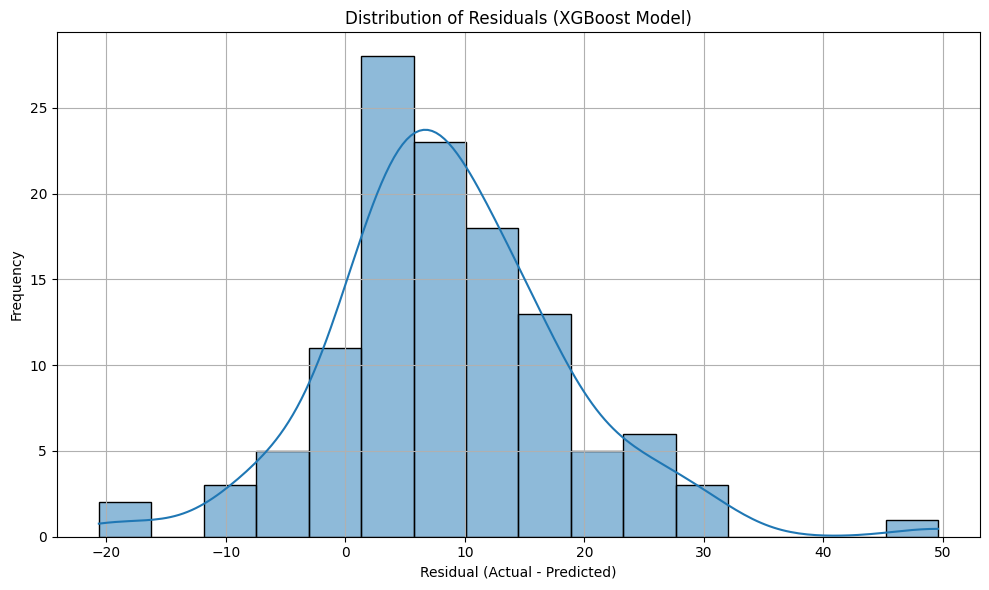

XGBoost Residuals plot saved to /content/residuals_distribution_xgboost.png
XGBoost model training and evaluation complete.

Generated XGBoost visualization and metrics files: ('/content/actual_vs_predicted_flu_index_xgboost.png', '/content/feature_importances_xgboost.png', '/content/residuals_distribution_xgboost.png', '/content/flu_prediction_xgboost_metrics.txt')

Script finished.


In [17]:
# 3. XGBoost
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from google.colab import files

# Define the path for the preprocessed file directly in /content
preprocessed_file = "/content/preprocessed_health_data.csv"

# Upload the preprocessed CSV file if it doesn't exist
print("Please upload the preprocessed_health_data.csv file")
uploaded = files.upload()
# Move the uploaded file to /content
for filename in uploaded.keys():
    os.rename(filename, preprocessed_file)
    print(f"Uploaded file moved to {preprocessed_file}")

def create_time_series_features(df):
    """
    Creates time series features from the Date index.
    """
    df_copy = df.copy()
    df_copy["week_of_year"] = df_copy.index.isocalendar().week.astype(int)
    df_copy["month"] = df_copy.index.month
    df_copy["year"] = df_copy.index.year
    return df_copy

def create_lagged_features(df, target_col, lags):
    """
    Creates lagged features for the target variable and other specified columns.
    """
    df_copy = df.copy()
    for lag in lags:
        df_copy[f"{target_col}_lag_{lag}"] = df_copy[target_col].shift(lag)
        if "Temperature" in df_copy.columns:
            df_copy[f"Temperature_lag_{lag}"] = df_copy["Temperature"].shift(lag)
        if "Total_Travellers" in df_copy.columns:
            df_copy[f"Total_Travellers_lag_{lag}"] = df_copy["Total_Travellers"].shift(lag)
    return df_copy

def train_and_evaluate_xgboost_model(data_file_path):
    """
    Loads preprocessed data, performs feature engineering, trains an XGBoost model,
    evaluates its performance, and displays visualizations.
    """
    print(f"Loading data from {data_file_path} for XGBoost model...")
    try:
        df = pd.read_csv(data_file_path, parse_dates=["Date"])
    except FileNotFoundError:
        print(f"Error: Preprocessed data file not found at {data_file_path}.")
        return None, None, None, None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None, None

    if df.empty:
        print("Preprocessed data is empty. Cannot train XGBoost model.")
        return None, None, None, None

    df.sort_values(by="Date", inplace=True)
    df.set_index("Date", inplace=True)

    print("Performing feature engineering for XGBoost...")
    # Create time-based and lagged features
    df = create_time_series_features(df)
    lags_to_create = [1, 2, 3, 4]
    df = create_lagged_features(df, "Flu_Index", lags_to_create)

    # Drop rows with NaNs created by lagging
    df.dropna(inplace=True)

    if df.empty:
        print("Data became empty after feature engineering (e.g., lagging). Cannot train XGBoost model.")
        return None, None, None, None

    print("Preparing features and target variable for XGBoost...")
    target = "Flu_Index"
    if target not in df.columns:
        print(f"Error: Target column '{target}' not found.")
        return None, None, None, None

    y = df[target]
    feature_cols = [col for col in df.columns if col != target and df[col].dtype in [np.float64, np.int64, np.uint32]]
    print(f"Selected features for XGBoost: {feature_cols}")
    X = df[feature_cols].copy()

    # Handle any remaining NaN values
    for col in X.columns:
        if X[col].isnull().any():
            print(f"Warning: XGBoost Feature '{col}' has {X[col].isnull().sum()} NaN values. Filling with median.")
            X[col].fillna(X[col].median(), inplace=True)

    if X.isnull().values.any():
        print("Error: NaN values still present in XGBoost features after filling. Please check data.")
        return None, None, None, None

    # Chronological split
    split_point = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
    y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]
    X_test_dates = X_test.index

    print(f"XGBoost Training data shape: X_train {X_train.shape}, y_train {y_train.shape}")
    print(f"XGBoost Testing data shape: X_test {X_test.shape}, y_test {y_test.shape}")

    if X_train.empty or X_test.empty:
        print("Error: XGBoost Training or testing set is empty.")
        return None, None, None, None

    print("Building and training XGBoost model...")
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train, verbose=False)
    print("Making predictions with XGBoost model on the test set...")
    y_pred = model.predict(X_test)

    print("Evaluating XGBoost model performance...")
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"  XGBoost MAE: {mae:.2f}")
    print(f"  XGBoost MSE: {mse:.2f}")
    print(f"  XGBoost RMSE: {rmse:.2f}")
    print(f"  XGBoost R-squared (R2): {r2:.2f}")

    metrics_summary_xgb = f"""
Flu Prediction Model Evaluation (XGBoost with Feature Engineering):
- Features: {feature_cols}
- Target: {target}
- Lags created: {lags_to_create}
- Training set size: {X_train.shape[0]}
- Testing set size: {X_test.shape[0]}
- MAE: {mae:.2f}
- MSE: {mse:.2f}
- RMSE: {rmse:.2f}
- R2 Score: {r2:.2f}
XGBoost Parameters:
{model.get_params()}
"""
    metrics_file_path = "/content/flu_prediction_xgboost_metrics.txt"
    with open(metrics_file_path, "w", encoding="utf-8") as f:
        f.write(metrics_summary_xgb)
    print(f"XGBoost prediction metrics saved to {metrics_file_path}")

    print("Generating and displaying XGBoost visualizations...")
    # 1. Actual vs. Predicted Plot
    plt.figure(figsize=(12, 6))
    plt.plot(X_test_dates, y_test, label="Actual Flu Index", color="blue")
    plt.plot(X_test_dates, y_pred, label="Predicted Flu Index (XGBoost)", color="green", linestyle="--")
    plt.title("Flu Index: Actual vs. Predicted (XGBoost Model)")
    plt.xlabel("Date")
    plt.ylabel("Flu Index (ILI_PMP)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    actual_vs_predicted_xgb_path = "/content/actual_vs_predicted_flu_index_xgboost.png"
    plt.savefig(actual_vs_predicted_xgb_path)
    plt.show()
    plt.close()
    print(f"XGBoost Actual vs. Predicted plot saved to {actual_vs_predicted_xgb_path}")

    # 2. Feature Importances Plot
    plt.figure(figsize=(10, max(6, len(X_train.columns) * 0.3)))
    sorted_idx = model.feature_importances_.argsort()
    plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx])
    plt.xlabel("XGBoost Feature Importance")
    plt.title("Feature Importances (XGBoost Model)")
    plt.tight_layout()
    feature_importance_xgb_path = "/content/feature_importances_xgboost.png"
    plt.savefig(feature_importance_xgb_path)
    plt.show()
    plt.close()
    print(f"XGBoost Feature Importances plot saved to {feature_importance_xgb_path}")

    # 3. Residuals Plot
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title("Distribution of Residuals (XGBoost Model)")
    plt.xlabel("Residual (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    residuals_plot_path = "/content/residuals_distribution_xgboost.png"
    plt.savefig(residuals_plot_path)
    plt.show()
    plt.close()
    print(f"XGBoost Residuals plot saved to {residuals_plot_path}")

    print("XGBoost model training and evaluation complete.")
    return actual_vs_predicted_xgb_path, feature_importance_xgb_path, residuals_plot_path, metrics_file_path

if __name__ == "__main__":
    print("Executing XGBoost Flu Trend Prediction script (flu_prediction_xgboost.py)...\n")
    results_xgb = train_and_evaluate_xgboost_model(preprocessed_file)
    if results_xgb and all(results_xgb):
        print(f"\nGenerated XGBoost visualization and metrics files: {results_xgb}")
    else:
        print("\nXGBoost model script run completed, but some outputs might be missing due to errors.")
    print("\nScript finished.")

Please upload the preprocessed_health_data.csv file


Saving preprocessed_health_data.csv to preprocessed_health_data.csv
Uploaded file moved to /content/preprocessed_health_data.csv
Executing Optimized XGBoost Pipeline...
Loading data from /content/preprocessed_health_data.csv...
Performing advanced feature engineering...
Splitting data with time-series validation...
Tuning XGBoost hyperparameters...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}
Training final model with native interface...
Making predictions...

=== Evaluation Results ===


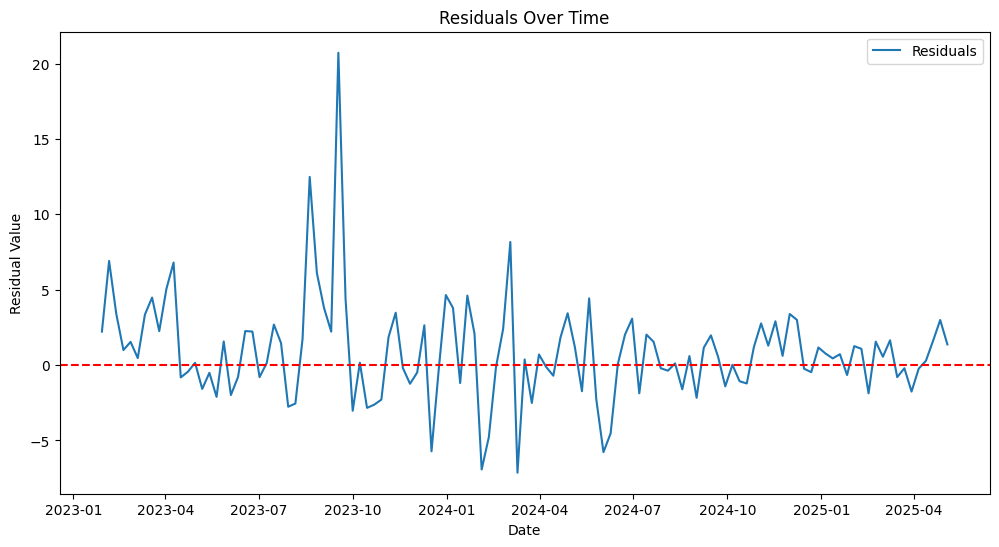

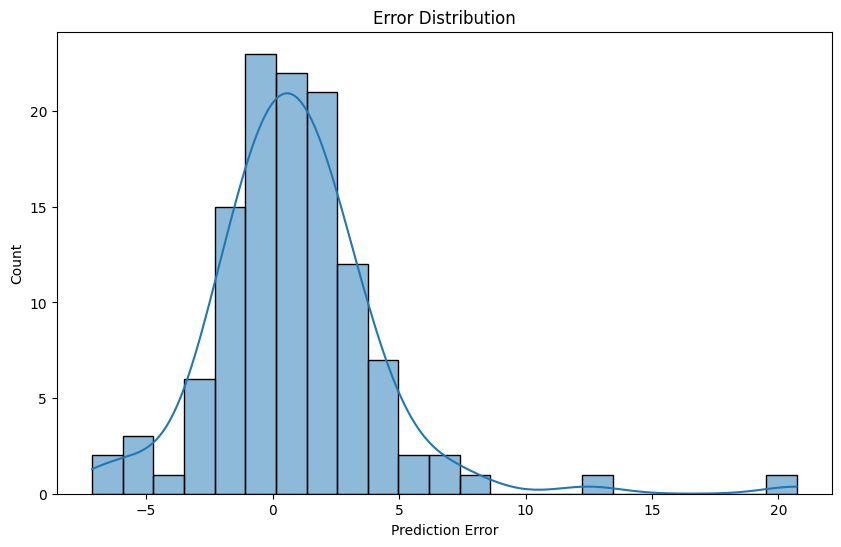

<Figure size 1200x800 with 0 Axes>

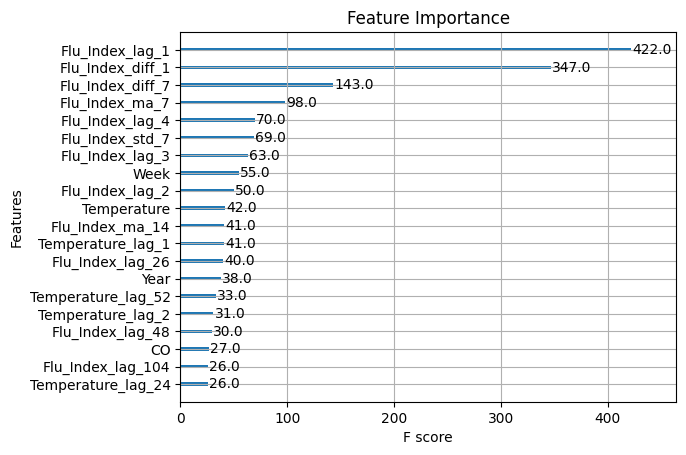

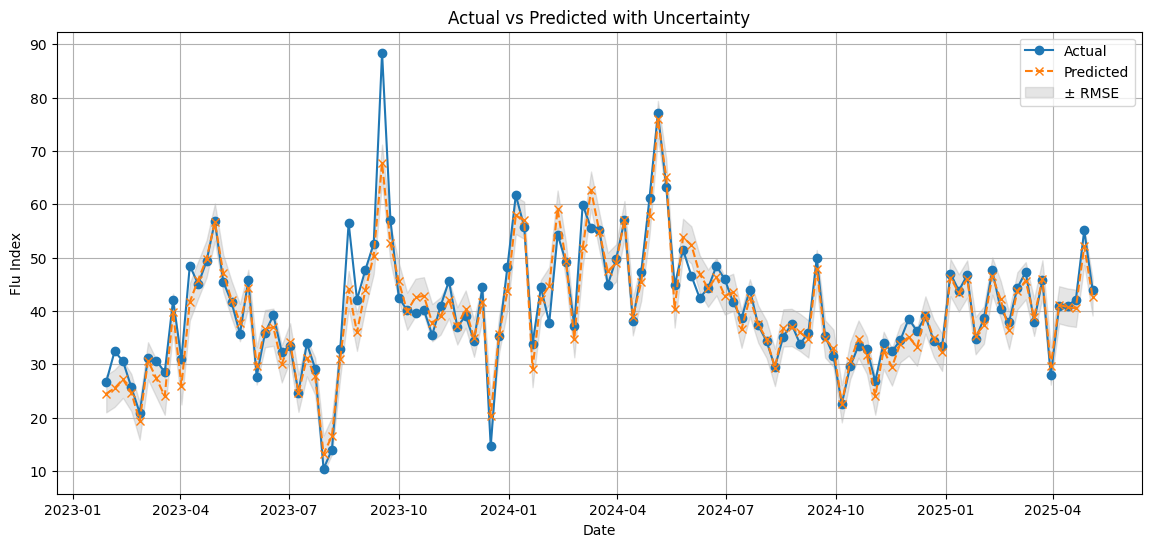


Model training completed successfully!
Final Metrics:
MAE: 2.3199
MSE: 12.2116
RMSE: 3.4945
R2: 0.9042
MAPE: 0.0594


In [1]:
# XGBoost with time series
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import xgboost as xgb
from pandas.tseries.holiday import USFederalHolidayCalendar
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

# Define the path for the preprocessed file directly in /content
preprocessed_file = "/content/preprocessed_health_data.csv"

# Upload the preprocessed CSV file if it doesn't exist
print("Please upload the preprocessed_health_data.csv file")
uploaded = files.upload()
# Move the uploaded file to /content
for filename in uploaded.keys():
    os.rename(filename, preprocessed_file)
    print(f"Uploaded file moved to {preprocessed_file}")

def enhanced_feature_engineering(df):
    """Enhanced feature engineering"""
    df = df.copy()

    # 1. Time features
    df["week_of_year"] = df.index.isocalendar().week.astype(int)
    df["month"] = df.index.month
    df["quarter"] = df.index.quarter
    df["year"] = df.index.year
    df["day_of_week"] = df.index.dayofweek

    # 2. Holiday features
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=df.index.min(), end=df.index.max())
    df["is_holiday"] = df.index.isin(holidays).astype(int)

    # 3. Lag features (extended windows)
    target_col = "Flu_Index"
    lag_windows = {
        'short_term': [1, 2, 3, 4],      # Short-term lags
        'seasonal': [24, 26, 52],        # Seasonal lags (assuming weekly data)
        'yearly': [48, 52, 104]          # Yearly cycles
    }

    for lag in [item for sublist in lag_windows.values() for item in sublist]:
        df[f"{target_col}_lag_{lag}"] = df[target_col].shift(lag)
        if "Temperature" in df.columns:
            df[f"Temperature_lag_{lag}"] = df["Temperature"].shift(lag)
        if "Total_Travellers" in df.columns:
            df[f"Travelers_lag_{lag}"] = df["Total_Travellers"].shift(lag)

    # 4. Rolling statistics
    windows = [7, 14, 28]  # Weekly, biweekly, monthly rolling
    for window in windows:
        df[f"Flu_Index_ma_{window}"] = df[target_col].rolling(window=window).mean()
        df[f"Flu_Index_std_{window}"] = df[target_col].rolling(window=window).std()

    # 5. Differencing
    df["Flu_Index_diff_1"] = df[target_col].diff(1)
    df["Flu_Index_diff_7"] = df[target_col].diff(7)

    # Handle missing values
    df = df.ffill().bfill()  # Forward fill then backward fill

    return df

def time_series_train_test_split(X, y, test_size=0.2):
    """Time series data splitting"""
    split_idx = int(len(X) * (1 - test_size))
    return X.iloc[:split_idx], X.iloc[split_idx:], y.iloc[:split_idx], y.iloc[split_idx:]

def tune_xgb_model(X_train, y_train):
    """Hyperparameter tuning"""
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'n_estimators': [100, 200, 300],
        'gamma': [0, 0.1, 0.2]
    }

    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )

    tscv = TimeSeriesSplit(n_splits=3)
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=20,
        scoring='neg_mean_absolute_error',
        cv=tscv,
        verbose=1
    )

    search.fit(X_train, y_train)
    print(f"Best parameters: {search.best_params_}")
    return search.best_estimator_

def advanced_evaluation(y_true, y_pred, dates):
    """Advanced evaluation methods"""
    # 1. Basic metrics
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }

    # 2. Residual analysis
    residuals = y_true - y_pred
    plt.figure(figsize=(12, 6))
    plt.plot(dates, residuals, label='Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals Over Time')
    plt.xlabel('Date')
    plt.ylabel('Residual Value')
    plt.legend()
    plt.show()

    # 3. Error distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Error Distribution')
    plt.xlabel('Prediction Error')
    plt.show()

    return metrics

def train_optimized_xgboost(data_file_path):
    print(f"Loading data from {data_file_path}...")
    try:
        df = pd.read_csv(data_file_path, parse_dates=["Date"], index_col="Date")
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

    print("Performing advanced feature engineering...")
    df = enhanced_feature_engineering(df)
    df = df.dropna()

    target = "Flu_Index"
    if target not in df.columns:
        print(f"Error: Target column '{target}' not found.")
        return None

    y = df[target]
    X = df.drop(columns=[target])

    print("Splitting data with time-series validation...")
    X_train, X_test, y_train, y_test = time_series_train_test_split(X, y, test_size=0.2)

    print("Tuning XGBoost hyperparameters...")
    best_model = tune_xgb_model(X_train, y_train)

    print("Training final model with native interface...")
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    params = {
        'objective': 'reg:squarederror',
        'max_depth': best_model.get_params()['max_depth'],
        'learning_rate': best_model.get_params()['learning_rate'],
        'subsample': best_model.get_params()['subsample'],
        'colsample_bytree': best_model.get_params()['colsample_bytree'],
        'gamma': best_model.get_params()['gamma'],
        'eval_metric': 'mae'
    }

    best_model = xgb.train(
        params,
        dtrain,
        num_boost_round=300,
        evals=[(dtest, 'eval')],
        early_stopping_rounds=20,
        verbose_eval=False
    )

    print("Making predictions...")
    y_pred = best_model.predict(xgb.DMatrix(X_test))

    print("\n=== Evaluation Results ===")
    metrics = advanced_evaluation(y_test, y_pred, X_test.index)

    # Feature importance visualization
    plt.figure(figsize=(12, 8))
    xgb.plot_importance(best_model, max_num_features=20)
    plt.title('Feature Importance')
    plt.show()

    # Prediction comparison plot
    plt.figure(figsize=(14, 6))
    plt.plot(X_test.index, y_test, label='Actual', marker='o')
    plt.plot(X_test.index, y_pred, label='Predicted', linestyle='--', marker='x')
    plt.fill_between(X_test.index,
                    y_pred - metrics['RMSE'],
                    y_pred + metrics['RMSE'],
                    alpha=0.2, color='gray', label='± RMSE')
    plt.title('Actual vs Predicted with Uncertainty')
    plt.xlabel('Date')
    plt.ylabel('Flu Index')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_model, metrics

if __name__ == "__main__":
    print("Executing Optimized XGBoost Pipeline...")
    model, metrics = train_optimized_xgboost(preprocessed_file)
    if model:
        print("\nModel training completed successfully!")
        print("Final Metrics:")
        for k, v in metrics.items():
            print(f"{k}: {v:.4f}")
    else:
        print("\nPipeline execution failed.")
